In [1]:
from typing import NamedTuple

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from doe_modules.design import CLOO, PlackettBurman, FullFactorial, DOptimization, d_criterion, DOCLOO
from doe_modules.plot import correlation_heatmap, design_heatmap, bio_scatterview
from doe_modules.preferences import kwarg_savefig, outputdir, heatmap_pref, dsmat_pref, textcolor
from doe_modules.preferences.cmap import sim1
from doe_modules.simulation import Sim1, MLR

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir

conf = Config()

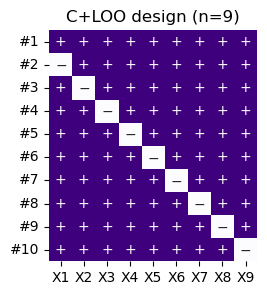

In [3]:
fig, ax = plt.subplots(figsize=(3, 3))

n_factor = 9

design_heatmap(
    design=CLOO, n_factor=n_factor, ax=ax, **dsmat_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/n={n_factor}", **kwarg_savefig)

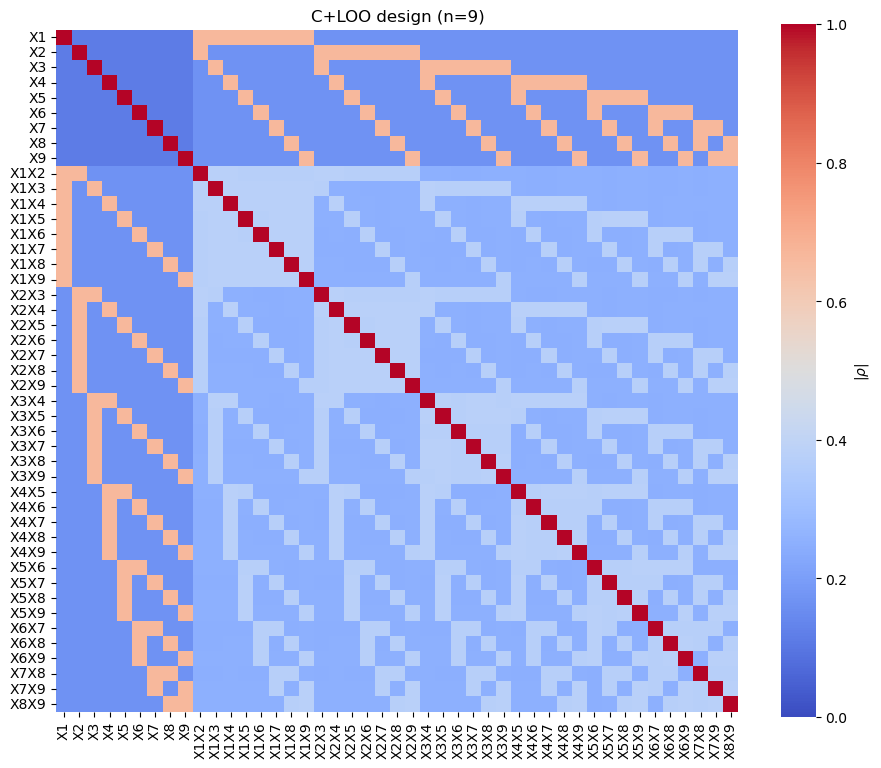

In [4]:
fig, ax = plt.subplots(figsize=(11, 9))

correlation_heatmap(
    design=CLOO, n_factor=9, ax=ax, **heatmap_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/corr_n={n_factor}", **kwarg_savefig)

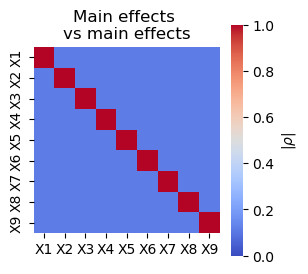

In [5]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.heatmap(
    CLOO().get_exmatrix(9)().corr().abs(), ax=ax, **heatmap_pref
)

ax.set(title="Main effects \nvs main effects")

if conf.savefig:
    fig.savefig(f"{conf.out}/main_n={n_factor}", **kwarg_savefig)

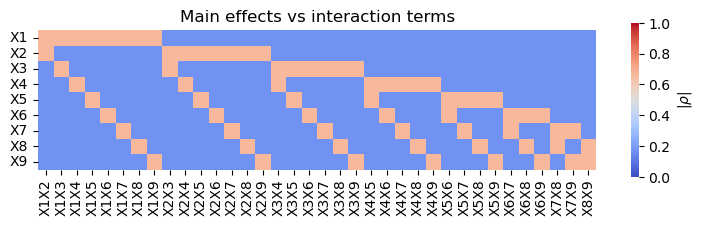

In [6]:
fig, ax = plt.subplots(figsize=(9, 2))

sns.heatmap(
    CLOO().get_exmatrix(9).interactions().corr().abs().iloc[:9, 9:], 
    ax=ax, **heatmap_pref
)

ax.set(title="Main effects vs interaction terms")

if conf.savefig:
    fig.savefig(f"{conf.out}/m&i_n={n_factor}", **kwarg_savefig)

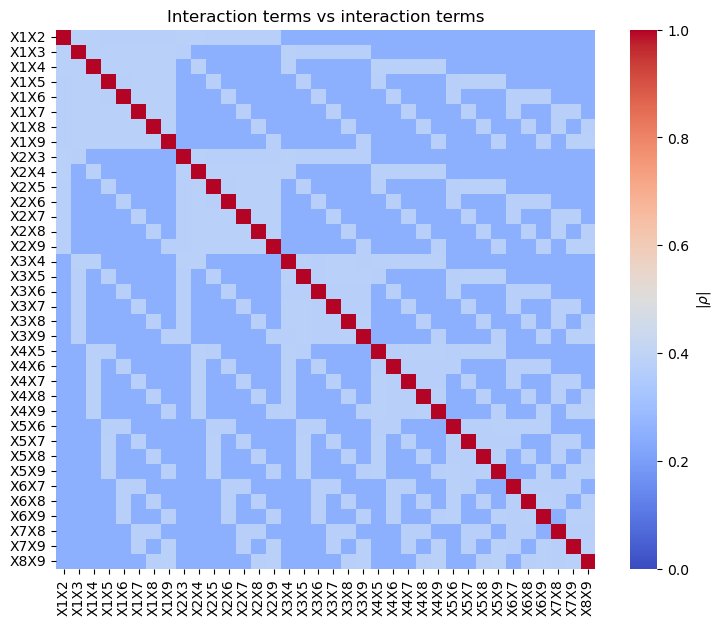

In [7]:
fig, ax = plt.subplots(figsize=(9, 7))

sns.heatmap(
    CLOO().get_exmatrix(9).interactions().corr().abs().iloc[9:, 9:], 
    ax=ax, **heatmap_pref
)

ax.set(title="Interaction terms vs interaction terms")

if conf.savefig:
    fig.savefig(f"{conf.out}/interaction_n={n_factor}", **kwarg_savefig)

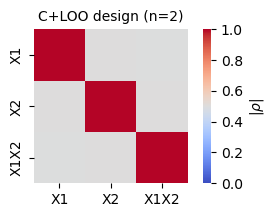

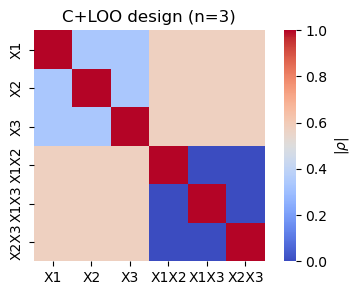

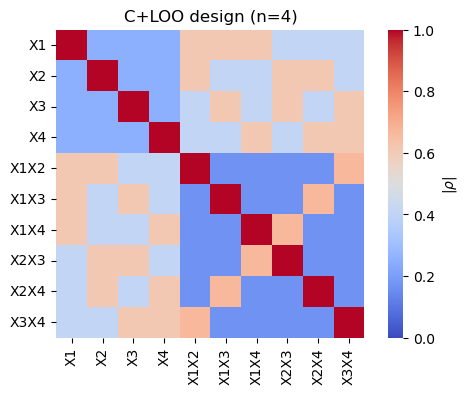

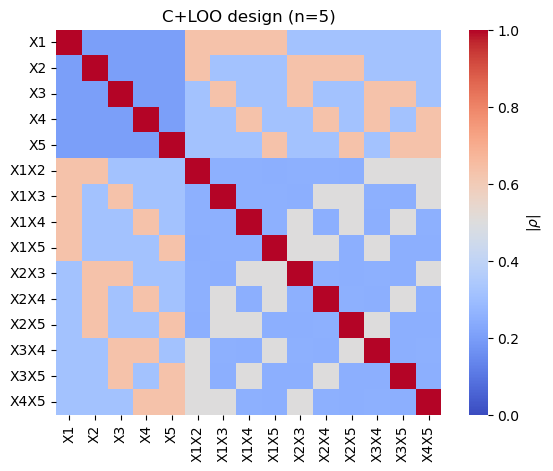

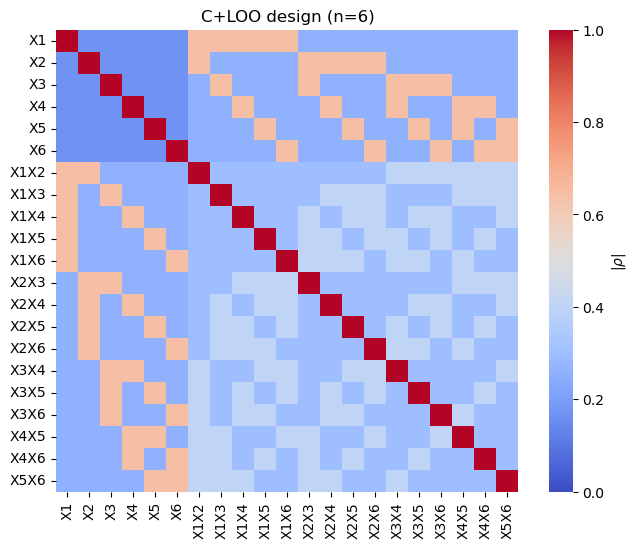

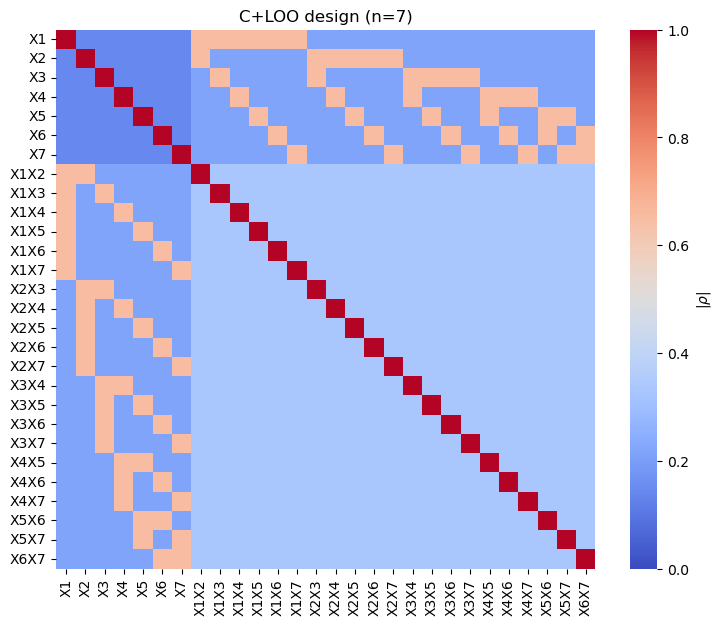

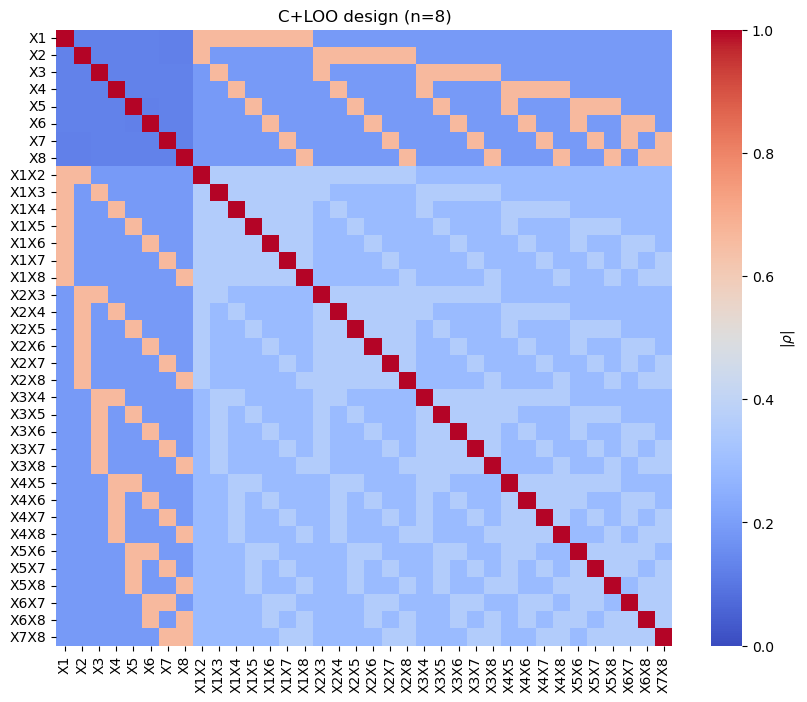

In [8]:
for n_f in [2, 3, 4, 5, 6, 7, 8]:
    fig, ax = plt.subplots(figsize=(n_f+2, n_f))

    correlation_heatmap(
        design=CLOO, n_factor=n_f, ax=ax, **heatmap_pref
    )
    ax.set_title(f"C+LOO design (n={n_f})", fontsize="medium" if n_f == 2 else "large")
    
    if conf.savefig:
        fig.savefig(f"{conf.out}/n={n_f}", **kwarg_savefig)

In [9]:
def main1_1(x: int) -> float:
    return 1 if x >= 1 else np.nan

def main1_2(x: int) -> float:
    return - 1 / x if x >= 2 else np.nan

def main1_int12(x: int) -> float:
    return np.sqrt((x - 1) / (2 * x)) if x >= 2 else np.nan

def main1_int23(x: int) -> float:
    return -np.sqrt(2 / (x * (x - 1))) if x >= 3 else np.nan

def int12_12(x: int) -> float:
    return 1 if x >= 1 else np.nan

def int12_13(x: int) -> float:
    return (x - 3) / (2 * (x - 1)) if x >= 3 else np.nan

def int12_34(x: int) -> float:
    return -2 / (x - 1) if x >= 4 else np.nan

In [10]:
m1m1 = np.vectorize(main1_1)
m1m2 = np.vectorize(main1_2)
m1i12 = np.vectorize(main1_int12)
m1i23 = np.vectorize(main1_int23)
i12i12 = np.vectorize(int12_12)
i12i13 = np.vectorize(int12_13)
i12i34 = np.vectorize(int12_34)

In [11]:
n = np.arange(12) + 1

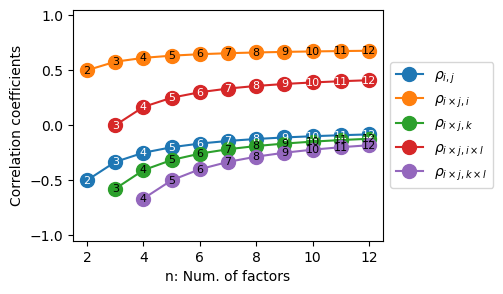

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))

# ax.plot(n, m1m1(n), label=r"$\rho_{i,i}$", marker="o")
ax.plot(n, m1m2(n), label=r"$\rho_{i,j}$", marker="o", markersize=10)
ax.plot(n, m1i12(n), label=r"$\rho_{i\times j,i}$", marker="o", markersize=10)
ax.plot(n, m1i23(n), label=r"$\rho_{i\times j,k}$", marker="o", markersize=10)
# ax.plot(n, i12i12(n), label=r"$\rho_{i\times j,i\times j}$", marker="o")
ax.plot(n, i12i13(n), label=r"$\rho_{i\times j,i\times l}$", marker="o", markersize=10)
ax.plot(n, i12i34(n), label=r"$\rho_{i\times j,k\times l}$", marker="o", markersize=10)

for i, f in enumerate([m1m2, m1i12, m1i23, i12i13, i12i34]):
    colorcodes = {idx: f"tab:{c}" for idx, c in enumerate(["blue", "orange", "green", "red", "purple"])}
    for x, y in zip(n, f(n)):
        if not np.isnan(y):
            ax.text(
                x, y, x, size=8, ha="center", va="center", 
                c=textcolor(mcolors.to_rgba(colorcodes[i]), dark="0")
            )

ax.set_ylim(-1.05, 1.05)
ax.legend(
    loc="center left", bbox_to_anchor=(1, .5), 
    # loc="lower right",
    # fontsize="x-small"
)
ax.set(ylabel="Correlation coefficients", xlabel="n: Num. of factors")

if conf.savefig:
        fig.savefig(f"{conf.out}/corr", **kwarg_savefig)

In [13]:
np.abs(m1i12(n))[-2:].mean()

0.6756015314247861

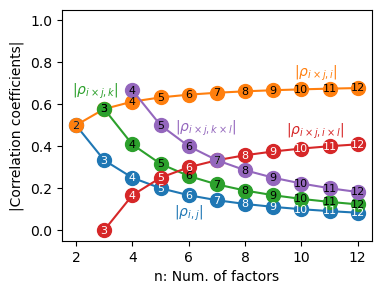

In [14]:
fig, ax = plt.subplots(figsize=(4, 3))

# ax.plot(n, np.abs(m1m1(n)), label=r"$|\rho_{i,i}|$", marker="o")
ax.plot(n, np.abs(m1m2(n)), label=r"$|\rho_{i,j}|$", marker="o", markersize=10)
ax.plot(n, np.abs(m1i12(n)), label=r"$|\rho_{i\times j,i}|$", marker="o", markersize=10)
ax.plot(n, np.abs(m1i23(n)), label=r"$|\rho_{i\times j,k}|$", marker="o", markersize=10)
# ax.plot(n, np.abs(i12i12(n)), label=r"$|\rho_{i\times j,i\times j}|$", marker="o")
ax.plot(n, np.abs(i12i13(n)), label=r"$|\rho_{i\times j,i\times l}|$", marker="o", markersize=10)
ax.plot(n, np.abs(i12i34(n)), label=r"$|\rho_{i\times j,k\times l}|$", marker="o", markersize=10)

for i, f in enumerate([m1m2, m1i12, m1i23, i12i13, i12i34]):
    colorcodes = {idx: f"tab:{c}" for idx, c in enumerate(["blue", "orange", "green", "red", "purple"])}
    for x, y in zip(n, abs(f(n))):
        if not np.isnan(y):
            ax.text(
                x, y, x, size=8, ha="center", va="center", 
                c=textcolor(mcolors.to_rgba(colorcodes[i]), dark="0")
            )


ax.set_ylim(-.05, 1.05)

ax.text(6, np.abs(m1m2(n))[5] - .04, r"$|\rho_{i,j}|$", ha="center", va="top", color="C0")
ax.text(10.5, np.abs(m1i12(n))[-3:-1].mean() + .03, r"$|\rho_{i\times j,i}|$", ha="center", va="bottom", color="C1")
ax.text(3.5, np.abs(m1i23(n))[2] + .04, r"$|\rho_{i\times j,k}|$", ha="right", va="bottom", color="C2")
ax.text(10.5, np.abs(i12i13(n))[-3:-1].mean() + .03, r"$|\rho_{i\times j,i\times l}|$", ha="center", va="bottom", color="C3")
ax.text(5.5, np.abs(i12i34(n))[5] + .04, r"$|\rho_{i\times j,k\times l}|$", ha="left", va="bottom", color="C4")

# ax.legend(
#     # loc="center left", bbox_to_anchor=(1, .5), 
#     loc="upper left",
#     fontsize="x-small"
# )
ax.set(ylabel="|Correlation coefficients|", xlabel="n: Num. of factors")

if conf.savefig:
        fig.savefig(f"{conf.out}/corr_abs", **kwarg_savefig)

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

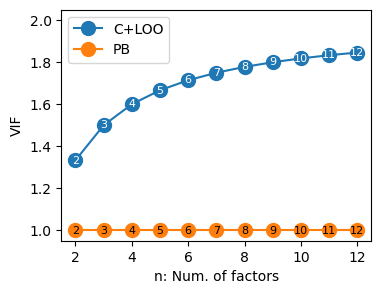

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))

vif_cloo = np.vectorize(lambda n: variance_inflation_factor(sm.add_constant(CLOO().get_exmatrix(n)().values), 1))
vif_pb = np.vectorize(lambda n: variance_inflation_factor(sm.add_constant(PlackettBurman().get_exmatrix(n)().values), 1))

x = np.arange(2, 13)
y_cloo, y_pb = vif_cloo(x), vif_pb(x)

ax.plot(x, y_cloo, marker="o", markersize=10, c="C0", label="C+LOO")
ax.plot(x, y_pb, marker="o", markersize=10, c="C1", label="PB")
ax.set_ylim(.95, 2.05)
ax.legend(
    # loc="center left", bbox_to_anchor=(1, .5), 
    loc="upper left",
    # fontsize="x-small"
)
ax.set(ylabel="VIF", xlabel="n: Num. of factors")

for xi, yi in zip(x, y_cloo):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C0"), dark="0"))
    
for xi, yi in zip(x, y_pb):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C1"), dark="0"))
    
if conf.savefig:
        fig.savefig(f"{conf.out}/vif", **kwarg_savefig)

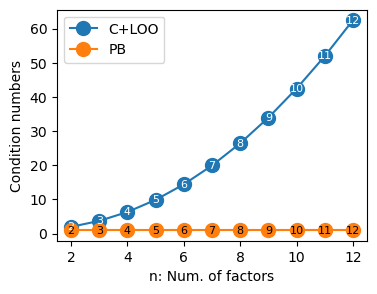

In [17]:
fig, ax = plt.subplots(figsize=(4, 3))

cond_cloo = np.vectorize(lambda n: np.linalg.cond(sm.add_constant(CLOO().get_exmatrix(n)().values)))
cond_pb = np.vectorize(lambda n: np.linalg.cond(sm.add_constant(PlackettBurman().get_exmatrix(n)().values)))
# cond_cloo = np.vectorize(lambda n: np.linalg.cond(CLOO().get_exmatrix(n)().values))
# cond_pb = np.vectorize(lambda n: np.linalg.cond(PlackettBurman().get_exmatrix(n)().values))

x = np.arange(2, 13)
y_cloo, y_pb = cond_cloo(x), cond_pb(x)

ax.plot(x, y_cloo, marker="o", markersize=10, c="C0", label="C+LOO")
ax.plot(x, y_pb, marker="o", markersize=10, c="C1", label="PB")
ax.legend(
    # loc="center left", bbox_to_anchor=(1, .5), 
    loc="upper left",
    # fontsize="x-small"
)
ax.set(ylabel="Condition numbers", xlabel="n: Num. of factors")

for xi, yi in zip(x, y_cloo):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C0"), dark="0"))
    
for xi, yi in zip(x, y_pb):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C1"), dark="0"))

if conf.savefig:
        fig.savefig(f"{conf.out}/condition_number", **kwarg_savefig)

In [18]:
def interaction_absorption(design, n_factor, order, n_rep=1):
    X = design().get_exmatrix(n_factor)
    P = lambda mat: mat @ np.linalg.inv(mat.T @ mat) @ mat.T
    PX = P(sm.add_constant(np.vstack([X().values] * n_rep)))
    X_int = np.vstack([X.interactions(order).iloc[:, n_factor:].values] * n_rep)
    return np.trace(X_int.T @ PX @ X_int) / np.trace(X_int.T @ X_int)

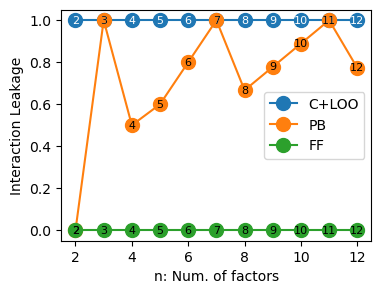

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))

x = np.arange(2, 13)
abs_cloo = np.vectorize(lambda n: interaction_absorption(CLOO, n, 2))(x)
abs_pb = np.vectorize(lambda n: interaction_absorption(PlackettBurman, n, 2))(x)
abs_ff = np.vectorize(lambda n: interaction_absorption(FullFactorial, n, 2))(x)

ax.plot(x, abs_cloo, marker="o", markersize=10, label="C+LOO")
ax.plot(x, abs_pb, marker="o", markersize=10, label="PB")
ax.plot(x, abs_ff, marker="o", markersize=10, label="FF")

ax.set(ylabel="Interaction Leakage", xlabel="n: Num. of factors")
ax.legend()

for xi, yi in zip(x, abs_cloo):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C0"), dark="0"))
    
for xi, yi in zip(x, abs_pb):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C1"), dark="0"))
    
for xi, yi in zip(x, abs_ff):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C2"), dark="0"))
    
if conf.savefig:
    fig.savefig(f"{conf.out}/interaction_leakage", **kwarg_savefig)

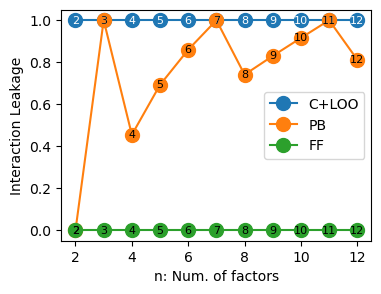

In [20]:
fig, ax = plt.subplots(figsize=(4, 3))

x = np.arange(2, 13)
abs_cloo = np.vectorize(lambda n: interaction_absorption(CLOO, n, np.inf))(x)
abs_pb = np.vectorize(lambda n: interaction_absorption(PlackettBurman, n, np.inf))(x)
abs_ff = np.vectorize(lambda n: interaction_absorption(FullFactorial, n, np.inf))(x)

ax.plot(x, abs_cloo, marker="o", markersize=10, label="C+LOO")
ax.plot(x, abs_pb, marker="o", markersize=10, label="PB")
ax.plot(x, abs_ff, marker="o", markersize=10, label="FF")

ax.set(ylabel="Interaction Leakage", xlabel="n: Num. of factors")
ax.legend()

for xi, yi in zip(x, abs_cloo):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C0"), dark="0"))
    
for xi, yi in zip(x, abs_pb):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C1"), dark="0"))
    
for xi, yi in zip(x, abs_ff):
    ax.text(xi, yi, xi, size=8, ha="center", va="center", c=textcolor(mcolors.to_rgba("C2"), dark="0"))
    
# if conf.savefig:
    # fig.savefig(f"{conf.out}/interaction_leakage", **kwarg_savefig)

---
# PB

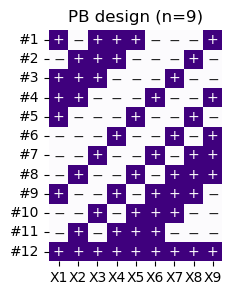

In [21]:
fig, ax = plt.subplots(figsize=(3, 3))

n_factor = 9

design_heatmap(
    design=PlackettBurman, n_factor=n_factor, ax=ax,
    **dsmat_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/pb_n={n_factor}", **kwarg_savefig)

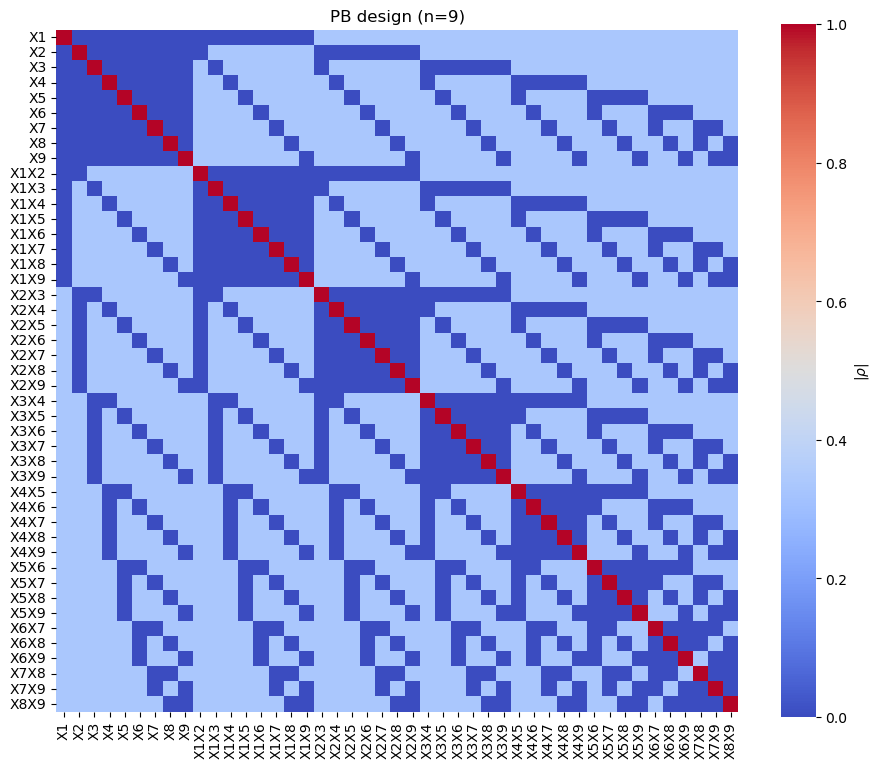

In [22]:
fig, ax = plt.subplots(figsize=(11, 9))

correlation_heatmap(
    design=PlackettBurman, n_factor=9, ax=ax,
    **heatmap_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/pb_corr_n={n_factor}", **kwarg_savefig)

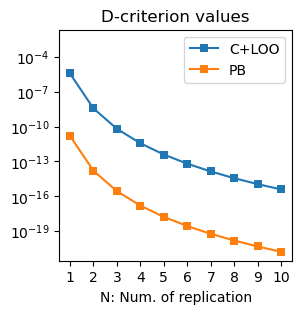

In [23]:
fig, ax = plt.subplots(figsize=(3, 3))

n_rep = 10

cloo = [pd.concat([CLOO().get_exmatrix(9)()] * (i + 1)) for i in range(n_rep)]
pb = [pd.concat([PlackettBurman().get_exmatrix(9)()] * (i + 1)) for i in range(n_rep)]

sns.lineplot(
    x=np.arange(1, n_rep + 1),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, cloo)), float),
    label="C+LOO", color="C0", marker="s", markeredgewidth=0,
)

sns.lineplot(
    x=np.arange(1, n_rep + 1),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, pb)), float),
    label="PB", color="C1", marker="s", markeredgewidth=0,
)

# ax.set_ylim(np.array(ax.get_ylim()) * np.array([1, 10]))
ax.set_xticks(np.arange(1, n_rep + 1), np.arange(1, n_rep + 1).astype(int))
ax.set_yscale("log")
ax.set_ylim(np.array(ax.get_ylim()) * np.array([1, 1000]))
ax.legend(loc="upper right")
ax.set(xlabel="N: Num. of replication", title="D-criterion values")

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmark_d", **kwarg_savefig)

---
# Full Factorial

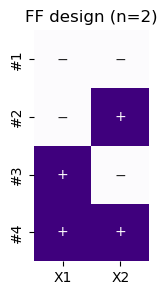

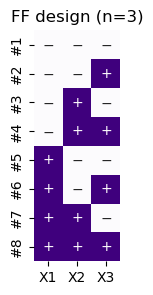

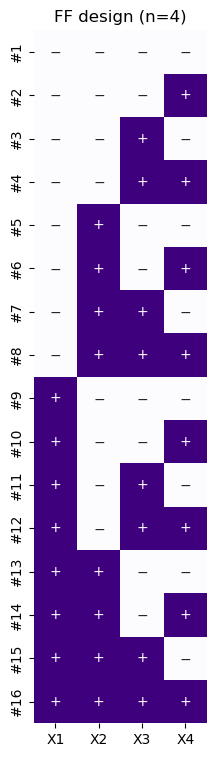

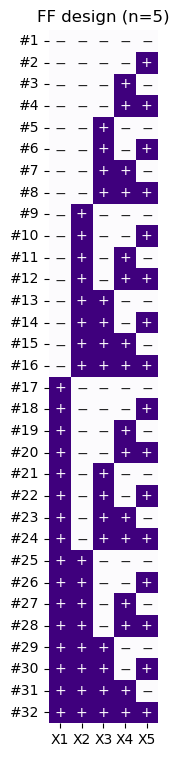

In [20]:
for n_factor in np.arange(2, 6):
    
    figsize = [(3, 3)] * 2 + [(3, 9)] * 2

    fig, ax = plt.subplots(figsize=figsize[n_factor - 2])

    design_heatmap(
        design=FullFactorial, n_factor=n_factor, ax=ax,
        **dsmat_pref
    )

    if conf.savefig:
        fig.savefig(f"{conf.out}/ff_n={n_factor}", **kwarg_savefig)

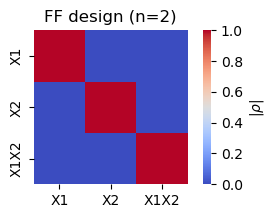

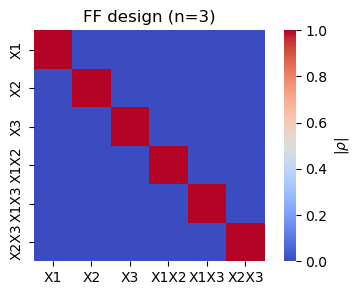

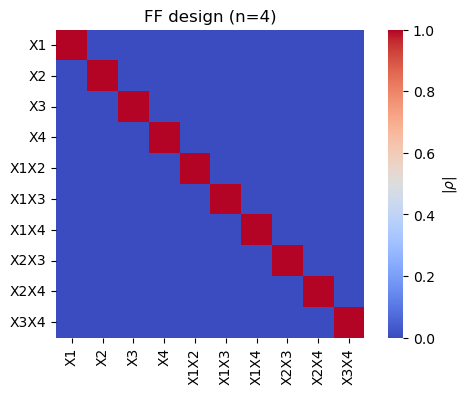

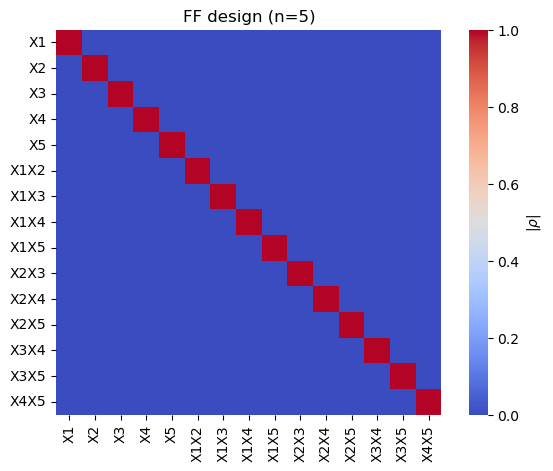

In [21]:
for n_f in np.arange(2, 6):
    fig, ax = plt.subplots(figsize=(n_f+2, n_f))

    correlation_heatmap(
        design=FullFactorial, n_factor=n_f, ax=ax,
        **heatmap_pref
    )

    if conf.savefig:
        fig.savefig(f"{conf.out}/ff_corr_n={n_f}", **kwarg_savefig)

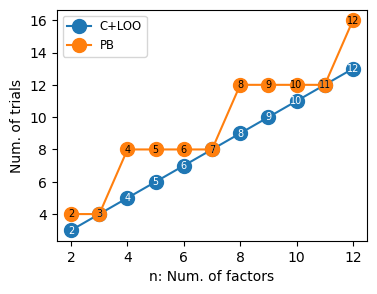

In [37]:
fig, ax = plt.subplots(figsize=(4, 3))

n_cloo = np.vectorize(lambda x: x + 1)
n_pb = np.vectorize(lambda x: 4 * (x // 4 + 1))
n_cloo2 = np.vectorize(lambda x: 2 * (x + 1))
n_pb2 = np.vectorize(lambda x: 8 * (x // 4 + 1))
n_cloo3 = np.vectorize(lambda x: 3 * (x + 1))
n_pb3 = np.vectorize(lambda x: 12 * (x // 4 + 1))

lim = 12

m = n[1:lim]
# dat = pd.DataFrame({
#     "n": np.concatenate([m] * 6),
#     "nmax": np.concatenate(
#         [n_cloo(m), n_pb(m)] + [2 * n_cloo(m), 2 * n_pb(m)] + [3 * n_cloo(m), 3 * n_pb(m)]
#     ),
#     "": (["C+LOO"] * (lim-1) + ["PB"] * (lim-1)) * 3,
#     "N: Num. of replication": [1] * 2 * (lim-1) + [2] * 2 * (lim-1) + [3] * 2 * (lim-1)
# })

ax.plot(m, n_cloo(m), marker="o", markersize=10, label="C+LOO")
ax.plot(m, n_pb(m), marker="o", markersize=10, label="PB")

# sns.lineplot(
#     data=dat, x="n", y="nmax", hue="", size="N: Num. of replication",
#     marker="o"
# )
# sns.scatterplot(
#     data=dat, x="n", y="nmax", hue="", legend=False, 
#     **dict(s=100), zorder=10, linewidth=0
# )

# for f in [n_cloo, n_pb, n_cloo2, n_pb2, n_cloo3, n_pb3]:
for i, f in enumerate([n_cloo, n_pb]):
    for x, y in zip(m, f(m)):
        ax.text(
            x, y, x, size=7, ha="center", va="center", zorder=11,
            c=textcolor(mcolors.to_rgba(f"C{i}"), dark="0")
        )

# ax.set_ylim(-.05, 1.05)
ax.legend(fontsize="small")
# ax.set(ylabel="$n_{max}$: total num. of trials", xlabel="n: Num. of factors")
ax.set(ylabel="Num. of trials", xlabel="n: Num. of factors")

if conf.savefig:
        fig.savefig(f"{conf.out}/n_max", **kwarg_savefig)

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


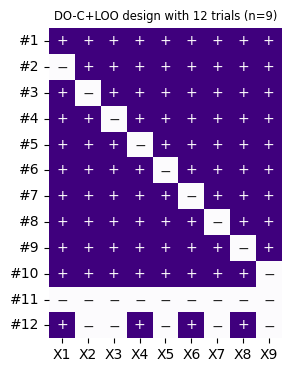

In [19]:
fig, ax = plt.subplots(figsize=(3, 6))

n_factor = 9
n_trials = 12

design_heatmap(
    design=DOCLOO, n_factor=n_factor, ax=ax,
    design_kws={"n_total": n_trials},
    **dsmat_pref
)

ax.set_title(ax.get_title(), fontsize="small")

if conf.savefig:
    fig.savefig(f"{conf.out}/doptim_{n_trials}trials", **kwarg_savefig)

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


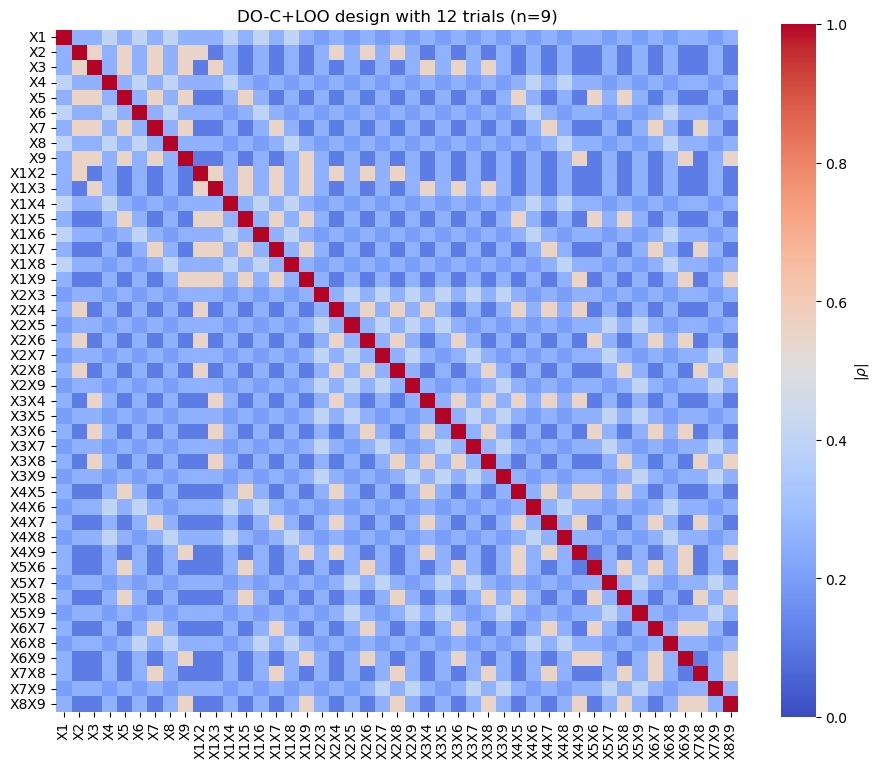

In [20]:
fig, ax = plt.subplots(figsize=(11, 9))

correlation_heatmap(
    design=DOCLOO, n_factor=9, ax=ax,
    design_kws={"n_total": 12},
    **heatmap_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/corr_doptim_{n_trials}trials", **kwarg_savefig)

In [21]:
lst_mat = [
    CLOO().get_exmatrix(9).values
] + [
    DOCLOO().get_exmatrix(9, i + 1).values for i in range(40)
]

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer

In [22]:
lst_pb = [
    PlackettBurman().get_exmatrix(9).values
] + [
    DOptimization(
        base=PlackettBurman
    ).get_exmatrix(9, i + 1).values for i in range(38)
]

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer

In [86]:
duplicate = lambda arr: np.vstack([arr] * 2)
triplicate = lambda arr: np.vstack([arr] * 3)

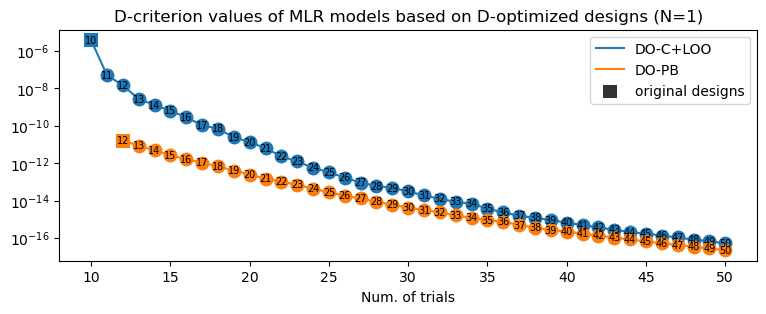

In [74]:
fig, ax = plt.subplots(figsize=(9, 3))

sns.lineplot(
    x=np.arange(10, 51),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float),
    label="DO-C+LOO", color="C0",
    linewidth=1.5
)
sns.scatterplot(
    x=np.arange(10, 51)[1:],
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float)[1:],
    color="C0", marker="o", s=100,
    linewidth=0
)

sns.lineplot(
    x=np.arange(12, 51),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_pb)), float),
    label="DO-PB", color="C1", 
    linewidth=1.5
)

sns.scatterplot(
    x=np.arange(12, 51)[1:],
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_pb)), float)[1:],
    color="C1", marker="o", s=100,
    linewidth=0
)

originals = [lst_mat[0], lst_mat[0], lst_pb[0]]

sns.scatterplot(
    x=[10, 10, 12], 
    y=np.fromiter(map(d_criterion, map(sm.add_constant, originals)), dtype=float),
    color=[".2", "C0", "C1"], marker=",", s=100,
    linewidth=0, label="original designs"
)

for xs, ys in zip(
    [np.arange(10, 51), np.arange(12, 51)], 
    [
        np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float),
        np.fromiter(map(d_criterion, map(sm.add_constant, lst_pb)), float)
    ]
):
    for x, y in zip(xs, ys):
        ax.text(x, y, x, size=7, ha="center", va="center", zorder=11)

ax.set(title="D-criterion values of MLR models based on D-optimized designs (N=1)", xlabel="Num. of trials")
ax.set_yscale("log")

xlim = ax.get_xlim()

if conf.savefig:
    fig.savefig(f"{conf.out}/doptim", **kwarg_savefig)

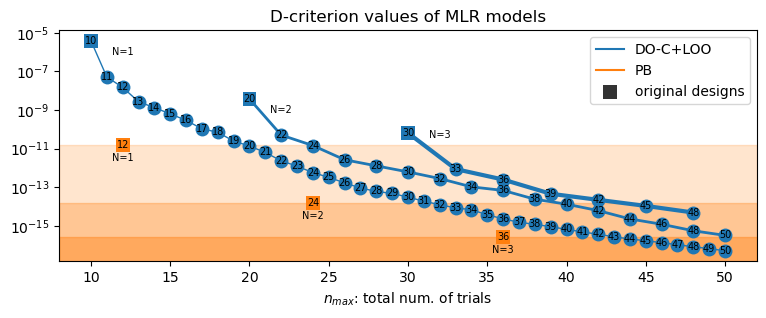

In [75]:
fig, ax = plt.subplots(figsize=(9, 3))

sns.lineplot(
    x=np.arange(10, 51),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float),
    color="C0", linewidth=1
)

sns.scatterplot(
    x=np.arange(10, 51)[1:],
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float)[1:],
    color="C0", marker="o", s=100, linewidth=0
)

sns.lineplot(
    x=np.arange(10, 51)[:16] * 2,
    y=np.fromiter(map(d_criterion, map(duplicate, map(sm.add_constant, lst_mat))), float)[:16],
    color="C0", linewidth=2
)

sns.scatterplot(
    x=np.arange(10, 51)[1:16] * 2,
    y=np.fromiter(map(d_criterion, map(duplicate, map(sm.add_constant, lst_mat))), float)[1:16],
    color="C0", marker="o", s=100, linewidth=0
)

sns.lineplot(
    x=np.arange(10, 51)[:7] * 3,
    y=np.fromiter(map(d_criterion, map(triplicate, map(sm.add_constant, lst_mat))), float)[:7],
    color="C0", linewidth=3
)

sns.scatterplot(
    x=np.arange(10, 51)[1:7] * 3,
    y=np.fromiter(map(d_criterion, map(triplicate, map(sm.add_constant, lst_mat))), float)[1:7],
    color="C0", marker="o", s=100, linewidth=0
)

sns.lineplot(x=[0], y=[0], label="DO-C+LOO", color="C0",)
sns.lineplot(x=[0], y=[0], label="PB", color="C1",)

originals = [
    sm.add_constant(lst_mat[0])
] * 2 + [
    duplicate(sm.add_constant(lst_mat[0])), 
    triplicate(sm.add_constant(lst_mat[0]))
] + [
    sm.add_constant(lst_pb[0]),
    duplicate(sm.add_constant(lst_pb[0])),
    triplicate(sm.add_constant(lst_pb[0]))
]

sns.scatterplot(
    x=[10, 10, 20, 30, 12, 24, 36], 
    y=np.fromiter(map(d_criterion, originals), dtype=float),
    color=[".2"] + ["C0"] * 3 + ["C1"] * 3, marker=",", s=100,
    linewidth=0, label="original designs"
)

y = ax.get_ylim()

ax.fill_between(xlim, d_criterion(sm.add_constant(lst_pb[0])), y[0], color="C1", alpha=.2, zorder=-100)
ax.fill_between(xlim, d_criterion(duplicate(sm.add_constant(lst_pb[0]))), y[0], color="C1", alpha=.3, zorder=-100)
ax.fill_between(xlim, d_criterion(triplicate(sm.add_constant(lst_pb[0]))), y[0], color="C1", alpha=.4, zorder=-100)

# ax.hlines(d_criterion(sm.add_constant(lst_pb[0])), *xlim, color="C1", alpha=1, zorder=-10)
# ax.hlines(d_criterion(duplicate(sm.add_constant(lst_pb[0]))), *xlim, color="C1", alpha=1, zorder=-10)
# ax.hlines(d_criterion(triplicate(sm.add_constant(lst_pb[0]))), *xlim, color="C1", alpha=1, zorder=-10)

pb_temp = [sm.add_constant(lst_pb[0]), duplicate(sm.add_constant(lst_pb[0])), triplicate(sm.add_constant(lst_pb[0]))]

for xs, ys in zip(
    [np.arange(10, 51), np.arange(10, 26) * 2, np.arange(10, 18) * 3, [12, 24, 36]], 
    [
        np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float),
        np.fromiter(map(d_criterion, map(duplicate, map(sm.add_constant, lst_mat))), float)[:16],
        np.fromiter(map(d_criterion, map(triplicate, map(sm.add_constant, lst_mat))), float)[:7],
        np.fromiter(map(d_criterion, pb_temp), float)
    ]
):
    for x, y in zip(xs, ys):
        ax.text(x, y, x, size=7, ha="center", va="center", zorder=11)


texts = ["N=1", "N=2", "N=3"] * 2
xs2 = [12, 22, 32, 12, 24, 36]
ys2 = [1e-6, 1e-9, 5e-11] + list(np.fromiter(map(d_criterion, pb_temp), float) / 5)

for x, y, t in zip(xs2, ys2, texts):
    ax.text(x, y, t, size=7, ha="center", va="center", zorder=11)

ax.set_xlim(xlim)

ax.set(
    title="D-criterion values of MLR models", 
    xlabel="$n_{max}$: total num. of trials"
)

# ax.set_ylim(ylim)
# ax.legend(fontsize="small")

ax.set_yscale("log")

if conf.savefig:
    fig.savefig(f"{conf.out}/doptim_nrep", **kwarg_savefig)